#  Генерация текста с использованием рекуррентных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Николенко С., Кадурин А., Архангельская Е. Глубокое обучение.
* https://pytorch.org/docs/stable/nn.html#recurrent-layers
* https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html


## Задачи для совместного разбора

1\. Рассмотрите основные шаги обучения модели для генерации текста с использованием RNN.

![text gen](https://www.tensorflow.org/static/text/tutorials/images/text_generation_sampling.png)

В этой ЛР мы рассматриваем задачу генерации текста. Верхнеуровнево это выглядит так: по текущему токену и некоторой информации о предыдущих токенах наша цель - сгенерировать следующий токен. Похожие вещи мы раньше делали, оценивая вероятностные распределения. Модель на биграммах - частный случай (история = один предыдущий токен).

Теперь мы усложняем модель и в качестве истории используем вектор скрытого состояния RNN, который получен после обработки части последовательности. Новый промежуточный вектор скрытого состояния можно использовать для прогноза следующего токена.

In [ ]:
import torch as th

batch_size, seq_len, vocab_size = 8, 5, 10
data = th.randint(0, vocab_size, size=(batch_size, seq_len)) # входные последовательности
data

tensor([[1, 5, 8, 1, 8],
        [1, 2, 7, 7, 0],
        [8, 6, 6, 3, 2],
        [4, 5, 1, 9, 6],
        [7, 3, 7, 2, 2],
        [0, 8, 0, 8, 0],
        [2, 2, 0, 8, 9],
        [5, 1, 2, 4, 2]])

Для обучения нужны примеры и ответы. Мы можем получить их из исходных данных, имея в виду решаемую задачу. Для конкретного токена правильный "ответ" в нашей постановке задачи - это следующий за ним токен

In [ ]:
X_t = X[:, :-1]
y_t = X[:, 1:]

In [ ]:
import torch.nn as nn

embedding_dim = 10
emb = nn.Embedding(num_embeddings=10, embedding_dim=embedding_dim) # каждый токен заменяем на вектор
X_e = emb(X_t)
X_e.shape

torch.Size([8, 4, 10])

In [ ]:
hidden_size = 7
rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)

out, h = rnn(X_e) # пропускаем последовательности через RNN
out.shape

torch.Size([8, 4, 7])

out - это векторы скрытых состояний после обработки очередного элемента последовательностей. Для каждого примера батча есть 4 (seq_len - 1) таких векторов. Каждый из них мы можем использовать для прогноза

In [ ]:
fc = nn.Linear(hidden_size, vocab_size)
y_preds = fc(out)
y_preds.shape

torch.Size([8, 4, 10])

На этом этапе у нас каждый из векторов имеет размерность 10 (по количеству уникальных токенов в словаре). Каждый из этих векторов трактуем как логиты. Цель - добиться того, чтобы логит, соответствующий правильному ответу (реально идущему далее слову) был побольше. В этом месте нам уже не нужна трехмерная структура.

In [ ]:
y_preds_2d = y_preds.reshape(batch_size * (seq_len - 1), -1)
y_preds_2d.shape

torch.Size([32, 10])

In [ ]:
y_t.flatten().shape

torch.Size([32])

Теперь можно посчитать значение функции потерь и поотпимизировать его в стандартном цикле обучения.

Во всей этой процедуре есть один токен, который будет встречаться очень часто - PAD. Вопрос: какое воздействие он должен оказывать на итоговое значение функции потерь? По факту, нас не интересуют прогнозы для этих токенов, т.к. они чисто служебные. Для учета этого факта можно рассмотреть параметр ignore_index при создании функции потерь.

## Задачи для самостоятельного решения

### 1.

<p class="task" id="1"></p>

1\. Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Tokenizer на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`. Выведите на экран количество токенов в полученном словаре.

- [ ] Проверено на семинаре

In [ ]:
import pandas as pd

data = pd.read_csv('pets_ru_en.csv')

In [ ]:
data.head()

,имя,язык
0,Acapella,en
1,Achilles,en
2,Adriana,en
3,Alpha,en
4,Alyssum,en


In [ ]:
import re

def preprocess(text):
  text = text.lower()
  text = re.sub(r'[^a-zа-яё]','',text)
  words = text.split()
  return ''.join(words)  # сделала так чтобы сложные имена были слитными

In [ ]:
data['имя'] = data['имя'].apply(preprocess)
data.head()

,имя,язык
0,acapella,en
1,achilles,en
2,adriana,en
3,alpha,en
4,alyssum,en


In [ ]:
data.shape

(2913, 2)

In [ ]:
data.isna().sum()

,0
имя,0
язык,0


In [ ]:
all_chars = []
for name in data['имя']:
    all_chars.extend(list(name))

all_chars[:5]

['a', 'c', 'a', 'p', 'e']

In [ ]:
from collections import Counter

char_count = Counter(all_chars)
char_count

Counter({'a': 733,
         'c': 283,
         'p': 242,
         'e': 753,
         'l': 429,
         'h': 209,
         'i': 507,
         's': 442,
         'd': 220,
         'r': 577,
         'n': 468,
         'y': 167,
         'u': 248,
         'm': 228,
         't': 378,
         'o': 488,
         'g': 152,
         'w': 88,
         'z': 45,
         'b': 183,
         'k': 121,
         'j': 26,
         'x': 40,
         'v': 62,
         'f': 127,
         'q': 5,
         'а': 1622,
         'с': 595,
         'я': 329,
         'л': 623,
         'и': 1101,
         'н': 575,
         'ф': 167,
         'в': 136,
         'р': 520,
         'о': 357,
         'д': 202,
         'е': 522,
         'ь': 154,
         'к': 534,
         'й': 101,
         'г': 124,
         'т': 386,
         'э': 145,
         'м': 317,
         'у': 263,
         'б': 143,
         'п': 165,
         'ш': 233,
         'з': 137,
         'ч': 120,
         'ё': 12,
         'ж': 98,


In [ ]:
unique_chars = sorted(char_count.keys())
unique_chars[:5]

['a', 'b', 'c', 'd', 'e']

In [ ]:
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
vocab = special_tokens + unique_chars
vocab[:5]

['<PAD>', '<SOS>', '<EOS>', 'a', 'b']

In [ ]:
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = {idx: char for idx, char in enumerate(vocab)}

In [ ]:
idx2char

{0: '<PAD>',
 1: '<SOS>',
 2: '<EOS>',
 3: 'a',
 4: 'b',
 5: 'c',
 6: 'd',
 7: 'e',
 8: 'f',
 9: 'g',
 10: 'h',
 11: 'i',
 12: 'j',
 13: 'k',
 14: 'l',
 15: 'm',
 16: 'n',
 17: 'o',
 18: 'p',
 19: 'q',
 20: 'r',
 21: 's',
 22: 't',
 23: 'u',
 24: 'v',
 25: 'w',
 26: 'x',
 27: 'y',
 28: 'z',
 29: 'а',
 30: 'б',
 31: 'в',
 32: 'г',
 33: 'д',
 34: 'е',
 35: 'ж',
 36: 'з',
 37: 'и',
 38: 'й',
 39: 'к',
 40: 'л',
 41: 'м',
 42: 'н',
 43: 'о',
 44: 'п',
 45: 'р',
 46: 'с',
 47: 'т',
 48: 'у',
 49: 'ф',
 50: 'х',
 51: 'ц',
 52: 'ч',
 53: 'ш',
 54: 'щ',
 55: 'ы',
 56: 'ь',
 57: 'э',
 58: 'ю',
 59: 'я',
 60: 'ё'}

In [ ]:
len(vocab)

61

### 2.

<p class="task" id="2"></p>

2\. Создайте класс `PetsGenDataset`. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами) и добавьте в начало каждого набора индекс `<SOS>`, а в конец - индекс токена `<EOS>`. Реализуйте `__getitem__` таким образом, чтобы он возвращал кортеж `(x, y)` в соответствии с приведенным рисунком. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

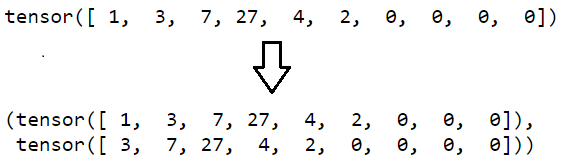

- [ ] Проверено на семинаре

In [ ]:
class PetsGenDataset:
  def __init__(self, names, vocab, max_length=20):
    self.names = names
    self.vocab = vocab
    self.max_length = max_length

  def __len__(self):
    return len(self.names)

  def __getitem__(self, idx):
    name = self.names[idx]
    ids = [self.vocab[char] for char in name]

    ids = [self.vocab['<SOS>']] + ids + [self.vocab['<EOS>']]

    if len(ids) < self.max_length:
      ids = ids + [self.vocab['<PAD>']] * (self.max_length - len(ids))
    else:
      ids = ids[:self.max_length]
      ids[-1] = self.vocab['<EOS>'] # последний токен дб EOS

    tensor = th.tensor(ids)

    x = tensor[:-1] # без последнего элемента
    y = tensor[1:] # смещен на 1

    return x, y

In [ ]:
names = data['имя'].to_list()
vocab = char2idx

dataset = PetsGenDataset(names, vocab, max_length=15)

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

batch_x, batch_y = next(iter(dataloader))
batch_x.shape, batch_y.shape

(torch.Size([128, 14]), torch.Size([128, 14]))

### 3.

<p class="task" id="3"></p>

3\. Напишите функцию, которая генерирует имя питомца при помощи обученной модели:
  * построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * начальное скрытое состояние RNN `h_t = None`;
  * в результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности;
  * функция возвращает строку из букв с первой заглавной буквой.
  
- [ ] Проверено на семинаре

In [ ]:
def generate_name(model, vocab, idx2char, max_length=20):
  model.eval()
  current_tok = th.tensor([[vocab['<SOS>']]])
  h_t = None
  generated_ids = []

  for _ in range(max_length):
    with th.no_grad():
      output, h_t = model(current_tok, h_t) # forward
      probs = th.softmax(output, dim=-1) # распр вер-ей
      current_tok = th.multinomial(probs, num_samples =1)
      generated_ids.append(current_tok.item())

      if current_tok.item() == vocab['<EOS>']: # если сгенерен <EOS>, остановка
        break

  generated_chars = [idx2char[idx] for idx in generated_ids if idx not in [vocab['<EOS>'], vocab['<SOS>']]]

  generated_chars[0] = generated_chars[0].upper()

  return ''.join(generated_chars)

### 4.

<p class="task" id="4"></p>

4\. Создайте и обучите модель для генерации имени питомца. Задача классификации ставится как предсказание следующего токена в каждом примере из пакета для каждого элемента последовательности (по прочитанной подстроке предсказывается следующий символ для данной строки). Каждые несколько эпох выводите примеры генерации имен при помощи текущего состояния модели. Игнорируйте токен `<PAD>` при расчете ошибки.

Примерная схема реализации метода `forward`:
```
input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size]
output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
```

- [ ] Проверено на семинаре

In [ ]:
import torch.nn as nn

class GeneratorModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(GeneratorModel, self).__init__()
    self.embed = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, vocab_size) # тк мы генерим символы

  def forward(self, x, h=None): # input_X: [batch_size x seq_len]
    emb_X = self.embed(x) # [batch_size x seq_len x embedding_size]
    out, h = self.rnn(emb_X, h) #  output: [batch_size x seq_len x hidden_size]
    # преобразую для лин слоя
    # out = out.reshape(batch_size * (seq_len - 1), -1)
    out = out.reshape(-1, out.shape[2]) # reshape -> output: [batch_size * seq_len x hidden_size]
    # -1 автоматом высчитывает этот размер (batch_size * seq_len),out.shape[2] - hidden_size
    out = self.fc(out) # nn.Linear -> output: [batch_size * seq_len x vocab_size]

    return out, h

при скорости обучения = 0.001:

In [ ]:
import torch.optim as optim

vocab_size = len(vocab)
embedding_dim = 64
hidden_size = 128

model = GeneratorModel(vocab_size, embedding_dim, hidden_size)

crit = nn.CrossEntropyLoss(ignore_index=char2idx['<PAD>'])
optim = optim.Adam(model.parameters(), lr = 0.001)

num_epochs = 100

for epoch in range(num_epochs):
  model.train()
  total_loss = 0

  for batch_x, batch_y in dataloader:
    optim.zero_grad()
    out, h = model(batch_x)
    loss = crit(out, batch_y.reshape(-1))  # в 1 строчку
    loss.backward()
    optim.step()

    total_loss +=loss.item()
  avg_loss = total_loss/len(dataloader)
  if epoch+1 == 1:
    print(f'Epoch [{epoch+1}/{num_epochs}], loss: {avg_loss:.4f}')
  elif (epoch+1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], loss: {avg_loss:.4f}')

  if (epoch+1) % 20 == 0:
    model.eval()
    print('\nпример генерации:')
    for _ in range(5):
      generated_name = generate_name(model, char2idx, idx2char)
      print(generated_name)
    print('\n')

Epoch [1/100], loss: 3.6340
Epoch [10/100], loss: 2.3289
Epoch [20/100], loss: 2.2003

пример генерации:
Thisker
Татя
Эллия
Эми
Дэйси


Epoch [30/100], loss: 2.1075
Epoch [40/100], loss: 2.0264

пример генерации:
Ришку
Gicke
Урсик
Chelliore
Юня


Epoch [50/100], loss: 1.9513
Epoch [60/100], loss: 1.8817

пример генерации:
Frose
Cote
Torper
Ксолина
Олныся


Epoch [70/100], loss: 1.8164
Epoch [80/100], loss: 1.7612

пример генерации:
Juloctina
Жезубл
Лапушка
Нори
Сафрина


Epoch [90/100], loss: 1.7104
Epoch [100/100], loss: 1.6629

пример генерации:
Лара
Ягма
Carmen
Blowella
Foxir




при скорости обучения = 0.01:

In [ ]:
import torch.optim as optim

vocab_size = len(vocab)
embedding_dim = 64
hidden_size = 128

model = GeneratorModel(vocab_size, embedding_dim, hidden_size)

crit = nn.CrossEntropyLoss(ignore_index=char2idx['<PAD>'])
optim = optim.Adam(model.parameters(), lr = 0.01)

num_epochs = 100

for epoch in range(num_epochs):
  model.train()
  total_loss = 0

  for batch_x, batch_y in dataloader:
    optim.zero_grad()
    out, h = model(batch_x)
    loss = crit(out, batch_y.reshape(-1))  # в 1 строчку
    loss.backward()
    optim.step()

    total_loss +=loss.item()
  avg_loss = total_loss/len(dataloader)
  if epoch+1 == 1:
    print(f'Epoch [{epoch+1}/{num_epochs}], loss: {avg_loss:.4f}')
  elif (epoch+1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], loss: {avg_loss:.4f}')

  if (epoch+1) % 20 == 0:
    model.eval()
    print('\nпример генерации:')
    for _ in range(5):
      generated_name = generate_name(model, char2idx, idx2char)
      print(generated_name)
    print('\n')

Epoch [1/100], loss: 2.8234
Epoch [10/100], loss: 2.0427
Epoch [20/100], loss: 1.7957

пример генерации:
Ophafry
Юки
Orcas
Шалинмейсен
Trisca


Epoch [30/100], loss: 1.6819
Epoch [40/100], loss: 1.5738

пример генерации:
Phece
Mony
Сэнди
Эсси
Полька


Epoch [50/100], loss: 1.5495
Epoch [60/100], loss: 1.5154

пример генерации:
Crurivona
Пузя
Teas
Иллиана
Рона


Epoch [70/100], loss: 1.5055
Epoch [80/100], loss: 1.4876

пример генерации:
Энилинка
Котти
Цезатаме
Герання
Тулисса


Epoch [90/100], loss: 1.4926
Epoch [100/100], loss: 1.4966

пример генерации:
Luscitus
Биал
Бастет
Spine
Ясмина




при lr=0.01 генерация лучше и ошибка меньше

### 5.

<p class="task" id="5"></p>

5\. Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Vocab на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`, `<RU>`, `<EN>`. Выведите на экран количество токенов в полученном словаре.

Модифицируйте датасет `PetsGenDataset` таким образом, чтобы в начало каждого примера добавлялся токен `<RU>`, если это имя питомца на русском, и `<EN>`, если имя на английском. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

- [ ] Проверено на семинаре

In [ ]:
import pandas as pd

data = pd.read_csv('pets_ru_en.csv')

In [ ]:
import re

def preprocess(text):
  text = text.lower()
  text = re.sub(r'[^a-zа-яё]','',text)
  words = text.split()
  return ''.join(words)  # сделала так чтобы сложные имена были слитными

In [ ]:
data['имя'] = data['имя'].apply(preprocess)
data.head()

,имя,язык
0,acapella,en
1,achilles,en
2,adriana,en
3,alpha,en
4,alyssum,en


In [ ]:
all_chars = []
for name in data['имя']:
    all_chars.extend(list(name))

all_chars[:5]

['a', 'c', 'a', 'p', 'e']

In [ ]:
from collections import Counter

char_count = Counter(all_chars)

In [ ]:
unique_chars = sorted(char_count.keys())
unique_chars[:5]

['a', 'b', 'c', 'd', 'e']

In [ ]:
special_tokens = ['<PAD>', '<SOS>', '<EOS>', '<RU>', '<EN>']
vocab = special_tokens + unique_chars
vocab[:7]

['<PAD>', '<SOS>', '<EOS>', '<RU>', '<EN>', 'a', 'b']

In [ ]:
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = {idx: char for idx, char in enumerate(vocab)}

In [ ]:
len(vocab)

63

In [ ]:
data['язык'].value_counts()

,count
язык,
rus,1783
en,1130


In [ ]:
class PetsGenDataset:
  def __init__(self, names, vocab, max_length=20, lang_col=None):
    self.names = names
    self.vocab = vocab
    self.max_length = max_length
    self.lang_col = lang_col

  def __len__(self):
    return len(self.names)

  def __getitem__(self, idx):
    name = self.names[idx]

    if self.lang_col is not None:
      lang = self.lang_col[idx]
      lang_token = '<RU>' if lang == 'rus' else '<EN>'

    ids = [self.vocab[char] for char in name]
    ids = [self.vocab[lang_token]] + [self.vocab['<SOS>']] + ids + [self.vocab['<EOS>']]

    if len(ids) < self.max_length:
      ids = ids + [self.vocab['<PAD>']] * (self.max_length - len(ids))
    else:
      ids = ids[:self.max_length]
      ids[-1] = self.vocab['<EOS>'] # последний токен дб EOS

    tensor = th.tensor(ids)

    x = tensor[:-1] # без последнего элемента
    y = tensor[1:] # смещен на 1

    return x, y

In [ ]:
names = data['имя'].to_list()
vocab = char2idx

dataset = PetsGenDataset(names, vocab, max_length=15, lang_col=data['язык'])

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

batch_x, batch_y = next(iter(dataloader))
batch_x.shape, batch_y.shape

(torch.Size([128, 14]), torch.Size([128, 14]))

In [ ]:
batch_x

tensor([[ 4,  1,  6,  ...,  0,  0,  0],
        [ 4,  1,  6,  ...,  0,  0,  0],
        [ 4,  1, 20,  ...,  0,  0,  0],
        ...,
        [ 4,  1,  5,  ...,  0,  0,  0],
        [ 4,  1,  6,  ...,  0,  0,  0],
        [ 4,  1, 15,  ...,  0,  0,  0]])

### 6.

<p class="task" id="6"></p>

6\. Модифицируйте функцию для генерации имени, добавив возможность указать первый токен - `<RU>` или `<EN>`. Создайте и обучите модель для генерации имени питомца с указанием языка. Каждые несколько эпох выводите примеры генерации русскоязычных и англоязычных имен при помощи текущего состояния модели . Игнорируйте токен `<PAD>` при расчете ошибки.

- [ ] Проверено на семинаре


In [ ]:
def generate_name(model, vocab, idx2char, max_length=20, lang_token=None):
  model.eval()
  h_t = None

  if lang_token is not None:
    current_tok = th.tensor([[vocab[lang_token]]])
    output, h_t = model(current_tok, h_t)

  current_tok = th.tensor([[vocab['<SOS>']]])
  generated_ids = []

  for _ in range(max_length):
    with th.no_grad():
      output, h_t = model(current_tok, h_t) # forward
      probs = th.softmax(output, dim=-1) # распр вер-ей
      current_tok = th.multinomial(probs, num_samples =1)
      generated_ids.append(current_tok.item())

      if current_tok.item() == vocab['<EOS>']: # если сгенерен <EOS>, остановка
        break

  generated_chars = [idx2char[idx] for idx in generated_ids # фильтр служ ток
                     if idx not in [vocab['<EOS>'], vocab['<SOS>'], vocab['<RU>'], vocab['<EN>']]]

  generated_chars[0] = generated_chars[0].upper()

  return ''.join(generated_chars)


In [ ]:
import torch.optim as optim

vocab_size = len(vocab)
embedding_dim = 64
hidden_size = 128

model = GeneratorModel(vocab_size, embedding_dim, hidden_size)

crit = nn.CrossEntropyLoss(ignore_index=char2idx['<PAD>'])
optim = optim.Adam(model.parameters(), lr = 0.01)

num_epochs = 100

for epoch in range(num_epochs):
  model.train()
  total_loss = 0

  for batch_x, batch_y in dataloader:
    optim.zero_grad()
    out, h = model(batch_x)
    loss = crit(out, batch_y.reshape(-1))  # в 1 строчку
    loss.backward()
    optim.step()

    total_loss +=loss.item()
  avg_loss = total_loss/len(dataloader)
  if epoch+1 == 1:
    print(f'Epoch [{epoch+1}/{num_epochs}], loss: {avg_loss:.4f}')
  elif (epoch+1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], loss: {avg_loss:.4f}')

  if (epoch+1) % 20 == 0:
    model.eval()
    print('\nпример генерации RU:')
    for _ in range(3):
      print(generate_name(model, char2idx, idx2char, lang_token='<RU>'))

    print('\nпример генерации ENG:')
    for _ in range(3):
      print(generate_name(model, char2idx, idx2char, lang_token='<EN>'))
    print('\n')

Epoch [1/100], loss: 2.5163
Epoch [10/100], loss: 1.7276
Epoch [20/100], loss: 1.5228

пример генерации RU:
Юфа
Викки
Елоксеспа

пример генерации ENG:
Tee
Carshie
Firivich


Epoch [30/100], loss: 1.3984
Epoch [40/100], loss: 1.3170

пример генерации RU:
Тейла
Патти
Марса

пример генерации ENG:
Guccay
Autcau
Safa


Epoch [50/100], loss: 1.2659
Epoch [60/100], loss: 1.2592

пример генерации RU:
Дыма
Тося
Шуся

пример генерации ENG:
Nikare
Abery
Magan


Epoch [70/100], loss: 1.2435
Epoch [80/100], loss: 1.2199

пример генерации RU:
Грация
Бетси
Белоснежиния

пример генерации ENG:
Moonger
Ares
Bella


Epoch [90/100], loss: 1.2516
Epoch [100/100], loss: 1.2327

пример генерации RU:
Ликки
Чантар
Гелла

пример генерации ENG:
Walex
Slackjakes
Casperidia


